In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=(-90, 90)),
                                        transforms.ToTensor()])


test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

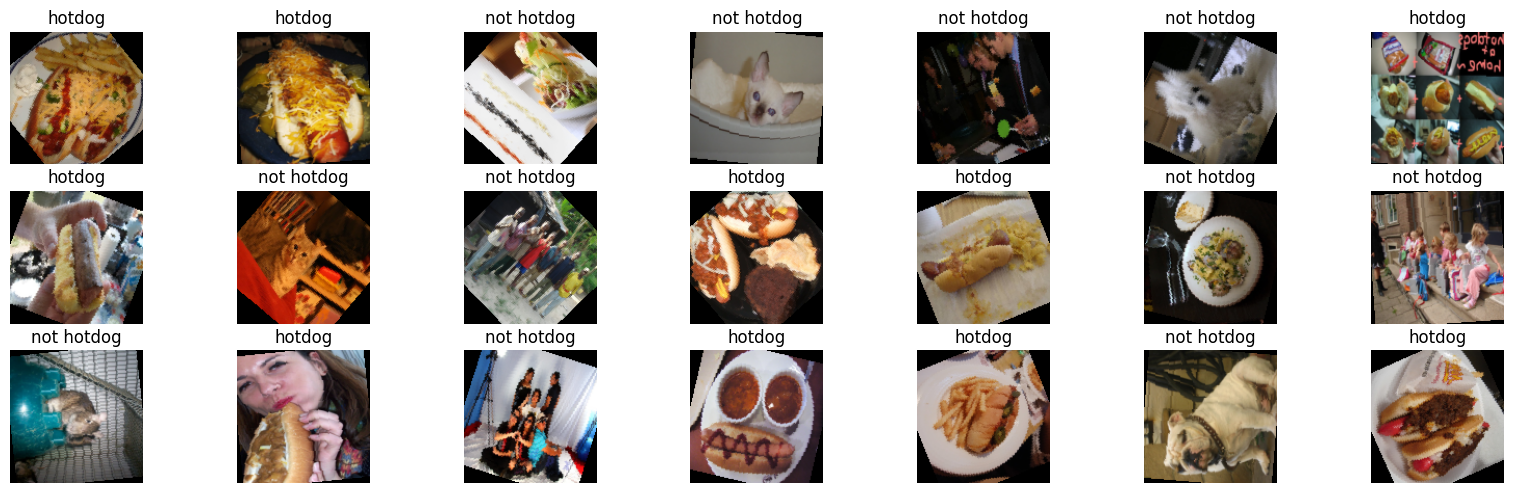

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [7]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target) 
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = nn.CrossEntropyLoss()(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [8]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = torch.optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.01)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
out_dict = train(model_ft, optimizer_adam, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.305	 test: nan	 Accuracy train: 85.8%	 test: 91.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.190	 test: nan	 Accuracy train: 92.6%	 test: 91.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.107	 test: nan	 Accuracy train: 96.1%	 test: 92.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.116	 test: nan	 Accuracy train: 95.1%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.102	 test: nan	 Accuracy train: 96.5%	 test: 92.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.072	 test: nan	 Accuracy train: 97.1%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.078	 test: nan	 Accuracy train: 97.2%	 test: 92.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.084	 test: nan	 Accuracy train: 97.2%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.077	 test: nan	 Accuracy train: 97.3%	 test: 91.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.066	 test: nan	 Accuracy train: 97.5%	 test: 90.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.043	 test: nan	 Accuracy train: 98.7%	 test: 91.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.064	 test: nan	 Accuracy train: 97.9%	 test: 91.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.061	 test: nan	 Accuracy train: 97.9%	 test: 92.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.055	 test: nan	 Accuracy train: 97.8%	 test: 91.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.068	 test: nan	 Accuracy train: 97.7%	 test: 92.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.065	 test: nan	 Accuracy train: 97.4%	 test: 91.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.048	 test: nan	 Accuracy train: 98.5%	 test: 91.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.057	 test: nan	 Accuracy train: 97.9%	 test: 91.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.071	 test: nan	 Accuracy train: 97.9%	 test: 92.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.056	 test: nan	 Accuracy train: 98.0%	 test: 92.5%


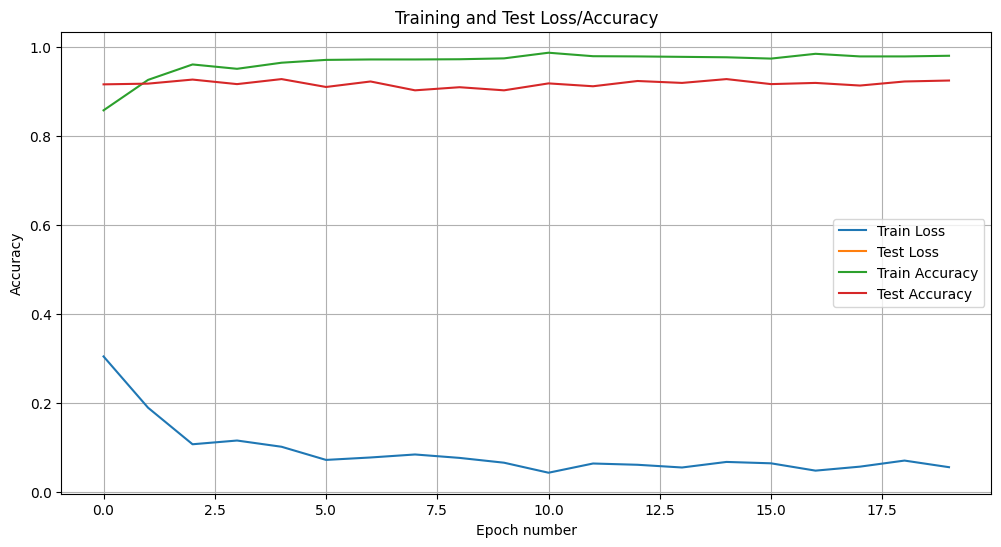

In [10]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.plot(out_dict['train_loss'], label='Train Loss')
plt.plot(out_dict['test_loss'], label='Test Loss')

# Plot Accuracy
plt.plot(out_dict['train_acc'], label='Train Accuracy')
plt.plot(out_dict['test_acc'], label='Test Accuracy')

plt.title('Training and Test Loss/Accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

# Add legends
plt.legend()

plt.grid(True)
plt.show()


Misclassified Example 1:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.8225957  0.17740427]]


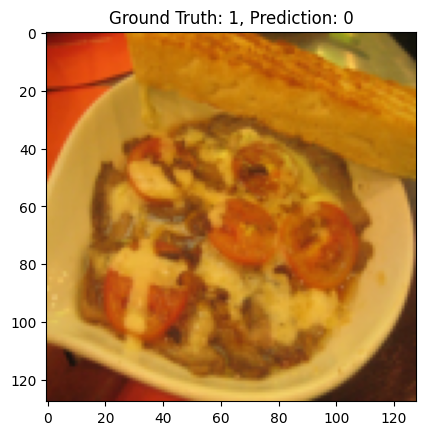


Misclassified Example 3:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[9.996840e-01 3.160881e-04]]


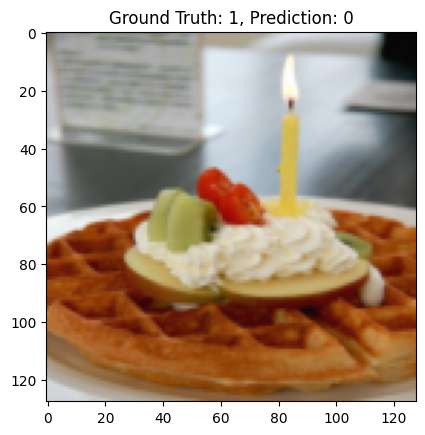


Misclassified Example 10:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.70160097 0.29839906]]


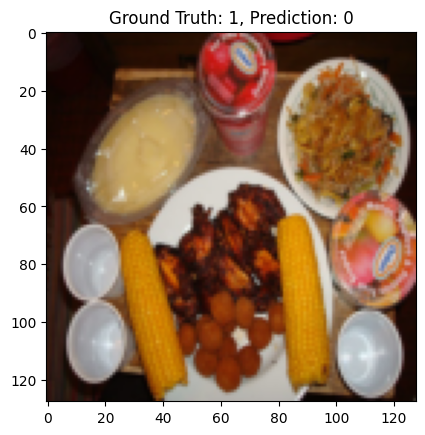


Misclassified Example 17:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.5585794  0.44142064]]


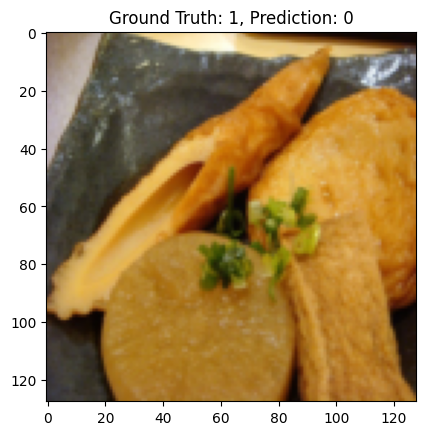


Misclassified Example 23:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.99893934 0.00106065]]


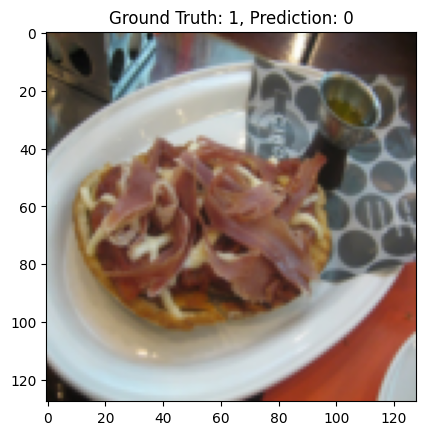


Misclassified Example 24:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.5497728  0.45022717]]


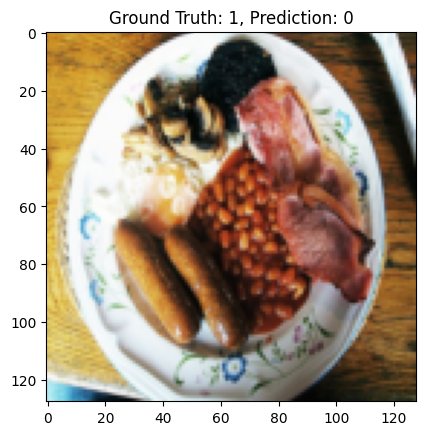


Misclassified Example 31:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.9989398  0.00106024]]


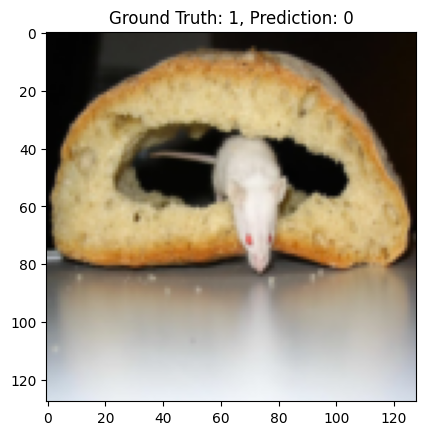


Misclassified Example 34:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.87736005 0.12263994]]


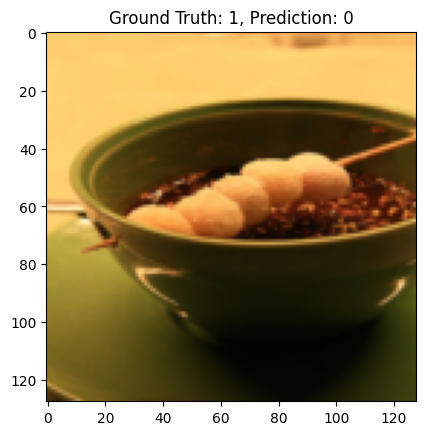


Misclassified Example 44:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.997698   0.00230201]]


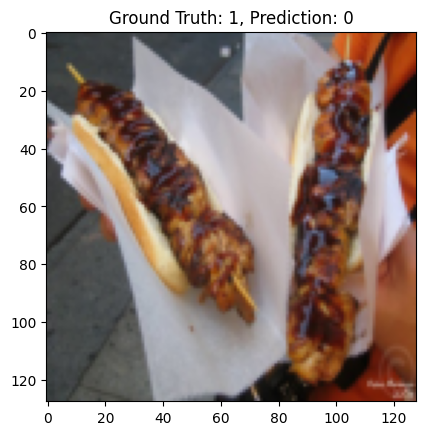


Misclassified Example 48:
Ground Truth: 1
Model Prediction: 0
Model Probabilities: [[0.69670194 0.3032981 ]]


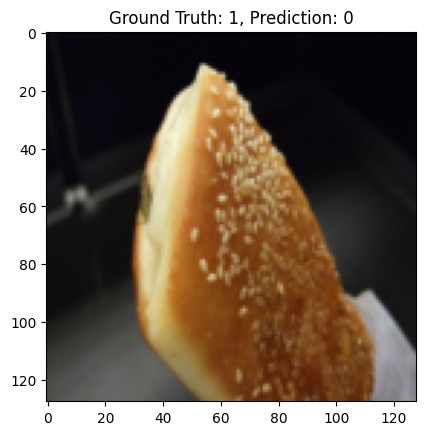

In [11]:
c = 0
with torch.no_grad():
    for i in range(len(test_loader.dataset)):
        example_data, example_target = test_loader.dataset[i+int(len(test_loader.dataset)/2)]
        example_data = example_data.unsqueeze(0).to(device)  # Add batch dimension
        example_output = model_ft(example_data)

        if example_target != example_output.argmax().item():
            c += 1
            print(f"\nMisclassified Example {i + 1}:")
            print("Ground Truth:", example_target)
            print("Model Prediction:", example_output.argmax().item())
            print("Model Probabilities:", torch.softmax(example_output, dim=1).cpu().numpy())

            # Display the associated MNIST image
            plt.imshow(example_data.squeeze().permute(1, 2, 0).cpu().numpy())
            plt.title(f"Ground Truth: {example_target}, Prediction: {example_output.argmax().item()}")
            plt.show()
        if c > 9:
            break

In [57]:
from captum.attr import Saliency

def compute_smoothgrad_saliency(model, input_data, target_class=None, num_samples=50, stdev_spread=0.15):
    # Create a Saliency object
    saliency = Saliency(model)

    # Generate SmoothGrad saliency map
    attributions = saliency.attribute(input_data, target=target_class)

    # Sum over color channels to get a grayscale saliency map
    attributions = attributions.sum(dim=1, keepdim=True)

    return attributions

/zhome/b9/5/181396/DLforCV/myenv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


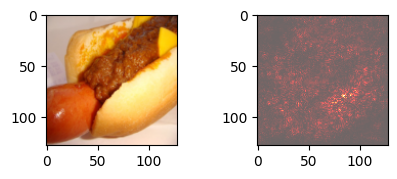

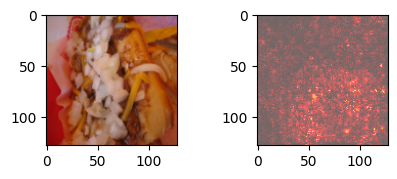

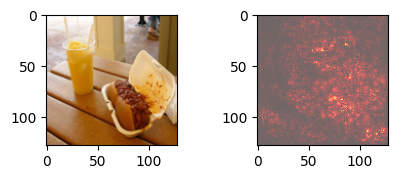

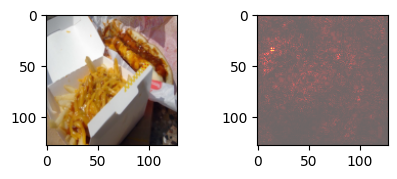

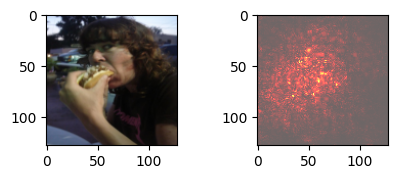

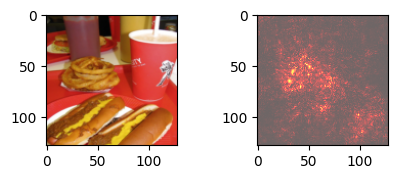

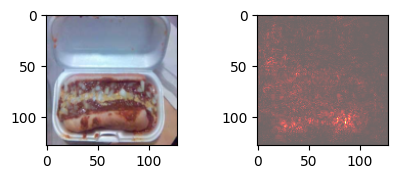

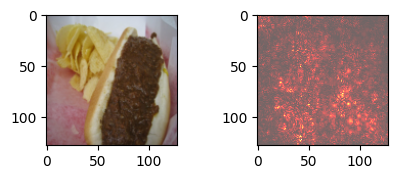

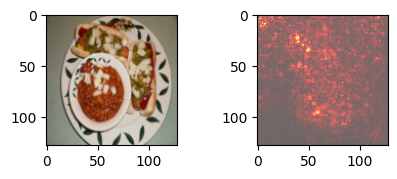

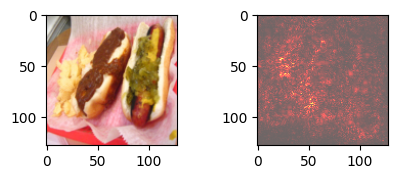

In [61]:
# Assuming you have a PyTorch model named 'model'
# Make sure 'model' is defined before running this code

# Set the model to evaluation mode
model_ft.eval()

# Choose some random examples from the test_loader
num_examples = 10
examples_data, examples_target = next(iter(test_loader))
examples_data = examples_data.to(device)  # Assuming 'device' is defined

# Compute SmoothGrad saliency map for each example
for i in range(num_examples):
    example_data = examples_data[i].unsqueeze(0)  # Add batch dimension
    target_class = examples_target[i].item()

    # Compute SmoothGrad saliency map
    saliency_map = compute_smoothgrad_saliency(model_ft, example_data, target_class=target_class)

    # Plot the original image
    plt.figure(figsize=(5,20))
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(example_data.squeeze().cpu().numpy().transpose(1, 2, 0), cmap='gray')
    #plt.title(f"Example {i + 1}\nOriginal Image")
    #plt.axis('off')

    # Plot the SmoothGrad saliency map
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(saliency_map.squeeze().cpu().numpy(), cmap='hot', alpha=0.6)
    #plt.title(f"Example {i + 1}\nSmoothGrad Saliency Map")
    #plt.axis('off')

plt.show()
